In [1]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import accuracy_score,brier_score_loss, roc_curve, auc, confusion_matrix
from scipy.stats import ks_2samp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import rpy2
from rpy2.robjects.packages import importr
hmeasure = importr("hmeasure")

In [2]:
def plot_roc(ax, actual,predicted,df_label):
    fpr, tpr, thresholds = roc_curve(actual,predicted)
    roc_auc=auc(fpr, tpr)
    lw = 2
    ax.plot(fpr, tpr, lw=lw, label='{} (AUC = {:.2f})'.format(df_label,roc_auc))
    tp = tpr * sum(actual)
    tn = (1 - fpr) * sum(1-actual)
    accvec = (tp + tn) / len(actual)
    best_threshold = thresholds[np.argmax(accvec)]
    tprfprdiff=tpr-fpr
    return roc_auc, 100*np.amax(accvec), best_threshold, max(tprfprdiff)

In [3]:
def plot_roc_mult(df_list):
    fig=plt.figure(figsize=[10, 10])
    ax = fig.add_subplot(1, 1, 1)  # create an axes object in the figure
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate',fontsize=18)
    ax.set_ylabel('True Positive Rate',fontsize=18)
    ax.set_title('Receiver operating characteristic',fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    CM_container=np.zeros((len(df_list),2,2))
    measures_container=pd.DataFrame(dtype=np.float32,index=df_list.keys(),
                                    columns=['Count','Missed','Proportion','Accuracy',
                                             'Sensitivity','Specificity','AUC','Brier Score','KS','H measure','Max Accuracy','Optimal threshold'])
    for ind, df_key in enumerate(df_list):
        df=df_list[df_key]
        ress = plot_roc(ax, df["actual"], df["scores"],df_key)
        CM_container[ind,:,:]=confusion_matrix(df["actual"], np.round(df["scores"]))
        measures_container['Count'][ind]=len(df["actual"])
        measures_container['Missed'][ind]=sum(df["actual"]==1)
        measures_container['Proportion'][ind]=100*sum(df["actual"]==1)/len(df["actual"])
        measures_container.Accuracy[ind]=100*accuracy_score(df["actual"], df["scores"]>0.5)
        measures_container.Sensitivity[ind]=100*CM_container[ind,1,1]/(CM_container[ind,1,1]+CM_container[ind,1,0])
        measures_container.Specificity[ind]=100*CM_container[ind,0,0]/(CM_container[ind,0,0]+CM_container[ind,0,1])
        measures_container.AUC[ind]=ress[0]
        measures_container['Brier Score'][ind]=100*brier_score_loss(df["actual"], df["scores"])
        measures_container['KS'][ind]=ress[3]
        measures_container['Max Accuracy'][ind]=ress[1]
        measures_container['Optimal threshold'][ind]=ress[2]
        Rscores = rpy2.robjects.FloatVector(df["scores"])
        Ractual = rpy2.robjects.IntVector(df["actual"])    
        res = hmeasure.HMeasure(Ractual, Rscores).rx('metrics')
        measures_container['H measure'][ind]=np.array(res[0].rx('H'))[0, 0]
    ax.legend(loc="lower right",fontsize=14)
    return CM_container, measures_container


In [4]:
def plot_calcur(df_list):
    plt.figure(figsize=[10, 10])
    plt.plot([0, 1], [0, 1], "k:")
    plt.ylabel("Fraction of positives",fontsize=18)
    plt.xlabel("Mean predicted value",fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    for ind, df_key in enumerate(df_list):
        df=df_list[df_key]
        fraction_of_positives, mean_predicted_value=calibration_curve(df["actual"],df["scores"],n_bins=10)
        plt.plot(mean_predicted_value, fraction_of_positives, "s-",label=df_key)
    plt.title("Calibration curve",fontsize=18)
    plt.legend(loc='upper left',fontsize=14);

[[[7537.  294.]
  [ 674. 1810.]]

 [[ 349.  188.]
  [ 180. 1730.]]

 [[ 174.  130.]
  [  86. 1535.]]

 [[  20.   48.]
  [  21. 1236.]]

 [[  10.   27.]
  [   9.  980.]]]


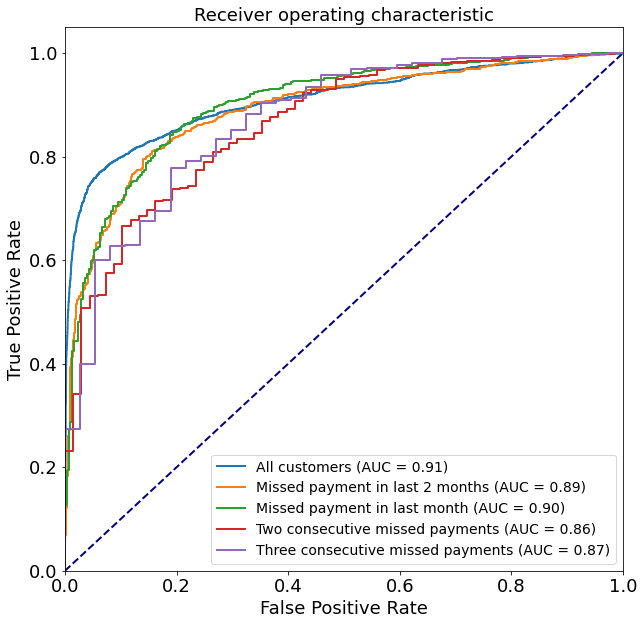

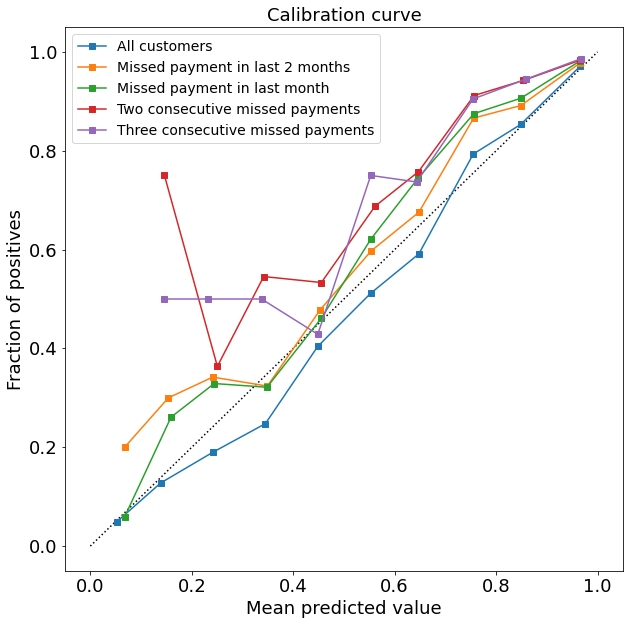

In [5]:
with open("../pickle/results_latefee.pickle", "rb") as fp:
    pred = pickle.load(fp)
with open("../pickle/df_cleaned.pickle", "rb") as fp:
    df = pickle.load(fp)
res=pred['test']
df_list={"All customers":res}
mask=(df.YEAR==2018)&(df.MONTH.isin([5,6]))&(df['TRANSACTION CODE']==605.0)
compromised=np.unique(df[mask]['Key'])
df_list['Missed payment in last 2 months']=res[res.Key.isin(compromised)]
mask=(df.YEAR==2018)&(df.MONTH.isin([6]))&(df['TRANSACTION CODE']==605.0)
compromised6=np.unique(df[mask]['Key'])
df_list['Missed payment in last month']=res[res.Key.isin(compromised6)]
mask=(df.YEAR==2018)&(df.MONTH.isin([5]))&(df['TRANSACTION CODE']==605.0)
compromised5=np.unique(df[mask]['Key'])
c56=np.intersect1d(compromised5,compromised6)
df_list['Two consecutive missed payments']=res[res.Key.isin(c56)]
mask=(df.YEAR==2018)&(df.MONTH.isin([4]))&(df['TRANSACTION CODE']==605.0)
compromised4=np.unique(df[mask]['Key'])
df_list['Three consecutive missed payments']=res[res.Key.isin(np.intersect1d(compromised4,c56))]

CM_container, measures_container=plot_roc_mult(df_list)
plot_calcur(df_list)
print(CM_container)

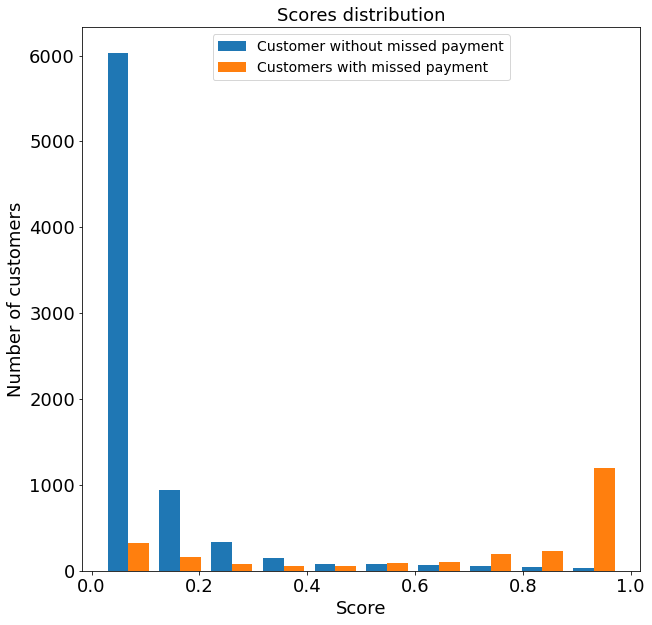

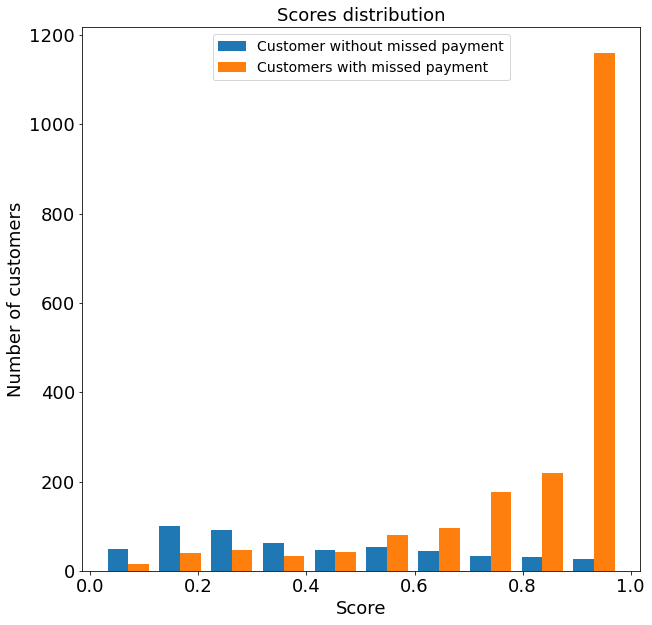

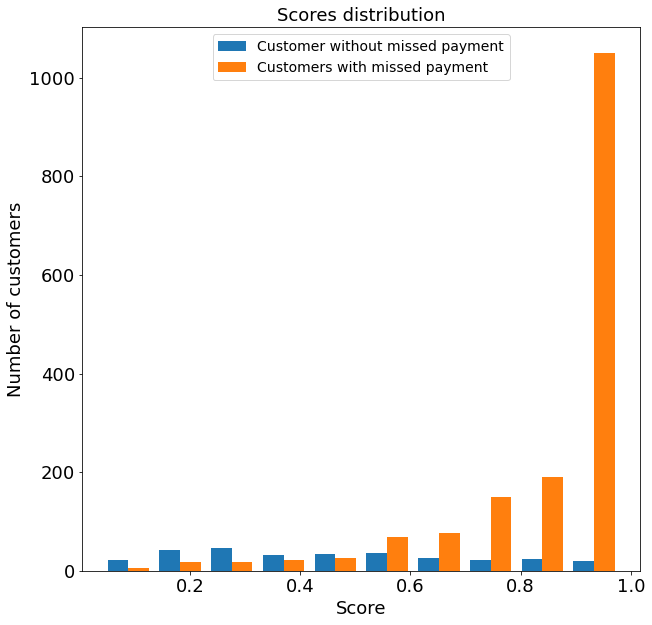

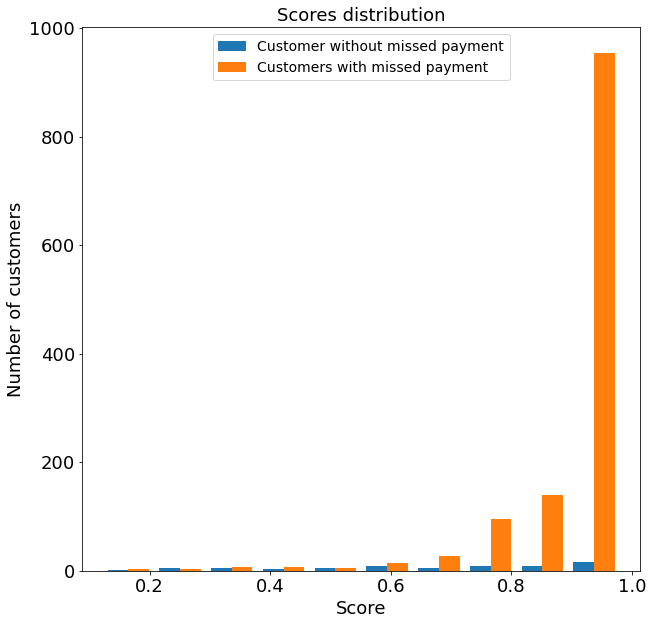

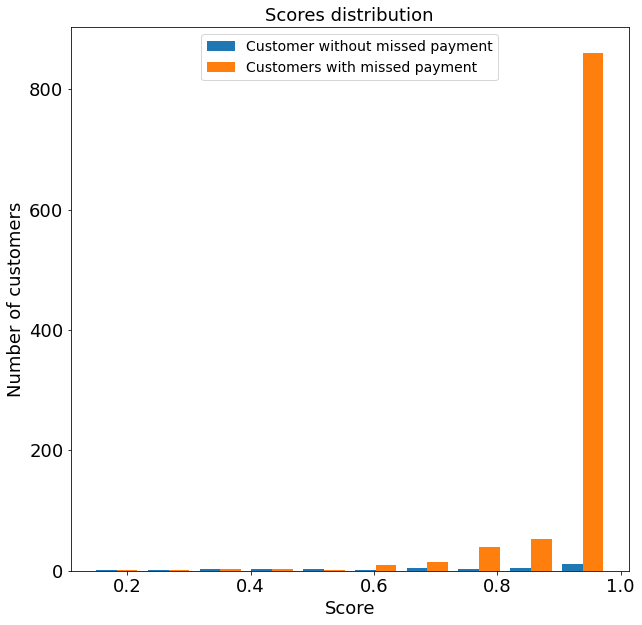

In [6]:
for ind, df_key in enumerate(df_list):
    df=df_list[df_key]
    plt.figure(figsize=[10, 10])
    ac0=df["scores"][df["actual"]==0]
    ac1=df["scores"][df["actual"]==1]
    plt.hist([ac0,ac1],label=["Customer without missed payment","Customers with missed payment"]);
    plt.title("Scores distribution",fontsize=18)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.xlabel("Score",fontsize=18)
    plt.ylabel("Number of customers",fontsize=18)
    plt.legend(loc='upper center',fontsize=14);

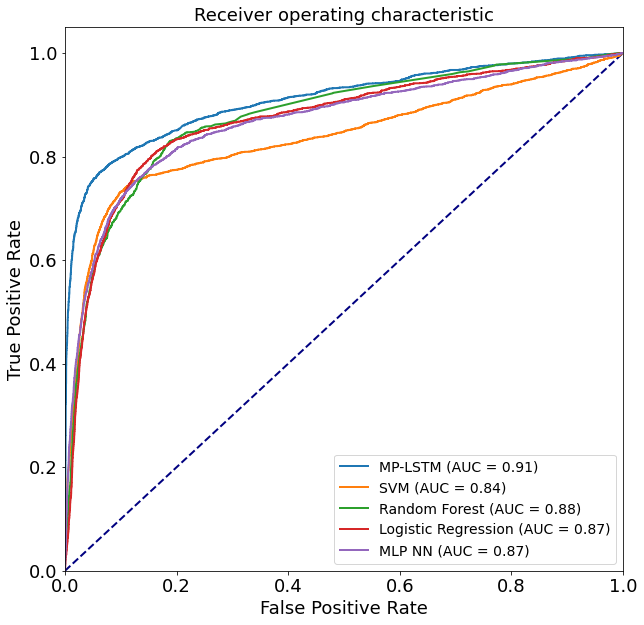

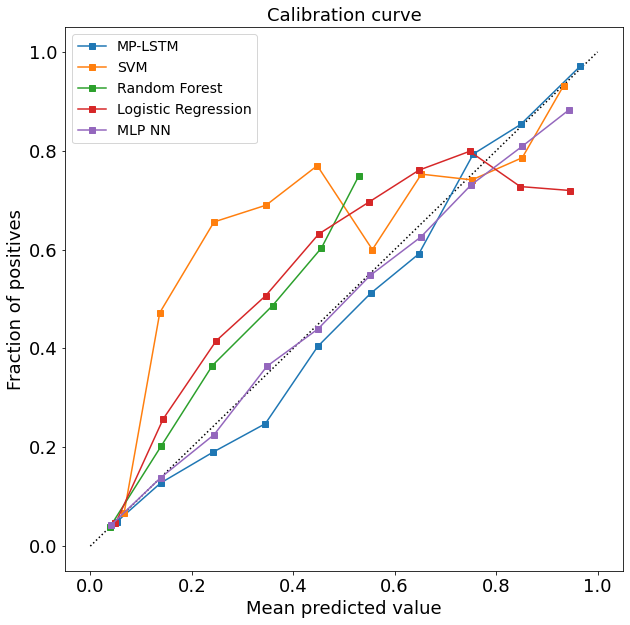

In [8]:
with open("../pickle/classifiers_allclients.pickle", "rb") as fp:
    all_cla = pickle.load(fp)
#all_cla['Neural Network'], all_cla['Logistic Regression'] = all_cla['Logistic Regression'], all_cla['Neural Network']
all_cla['MLP NN'] = all_cla.pop('Neural Network')
df_list={'MP-LSTM':res}
for i in all_cla:
    df_list[i]=all_cla[i]['test']
CM_container, measures_container_all=plot_roc_mult(df_list)
plot_calcur(df_list)
with pd.ExcelWriter('output.xlsx') as writer: 
    measures_container.round(2).to_excel(writer, sheet_name='LSTM')
    measures_container_all.round(2).to_excel(writer, sheet_name='All')